***
**Durham University | MISCADA | Scientific Computing and Data Analysis<br>
Deep Learning for Computer Vision and Robotics | COMP52715 | Coursework: Task 1 - 3D PacMan <br>
Teng Wang | dgwz78 | Apr 2024**
***

<div class="alert alert-info">
  Please read my report before check the code. You can just clone my full files on <a href="https://github.com/Adrian6476/dl-cv-robotics">GitHub Link</a>.
</div>

>```bash
>git clone git@github.com:Adrian6476/dl-cv-robotics.git
>or
>git clone https://github.com/Adrian6476/dl-cv-robotics.git
```

## Imports
Here we will do our usual imports. I would recommend numpy, scipy, skimage, sklearn, pytorch, and matplotlib. If you wish to utilise pointcloud visualisation then you can do that as described in the handout via Open3D. We will want to import our PacMan_Helper module as well.

In [2]:
# I modified the PacMan_Helper.py code to accelerate the points_to_images() function using numba and also added some useful functions. Comparison of acceleration results can be seen in Benchmark.ipynb
from lib import PacMan_Helper_Accelerated as PacMan 
# import any package that requires
import os
import time
import numpy as np
import copy

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from ultralytics import YOLO
from ultralytics.utils.benchmarks import benchmark
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import open3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Game setup.
This cell will initialise the game world and add all of our spheres to the world. Do not edit the code here.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPU to accelerate
if device.type == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)
    print(f'Using GPU: {gpu_name}')
else:
    print('CUDA is not available, using CPU.')

Using GPU: NVIDIA GeForce RTX 3070


In [4]:
# Call startup_scene() to load the initial game scene
global_cloud, spheres_collected = PacMan.startup_scene()

In [4]:
# View our pointcloud if we want
pcd = open3d.geometry.PointCloud(open3d.utility.Vector3dVector(global_cloud['Positions']))
pcd.colors = open3d.utility.Vector3dVector(global_cloud['Colors']/255)

open3d.visualization.draw_geometries([pcd])

## Load the training data: Positives and Negatives
In the handout zip file there is a directory which contains numerous patches extracted from sample images. These patches are labelled as either containing a sphere or not. You may wish to use these to train a classifier for sphere detection. This classifier can then be used later to detect spheres and move our camera towards them.

In [4]:
class PacmanDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Initialise data set
        :param root_dir: file path which contains 'positives' and 'negatives' 
        :param transform: the transformation operation to be applied to each image
        """
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Load positives
        pos_dir = os.path.join(root_dir, 'positives')
        self.images += [os.path.join(pos_dir, file) for file in os.listdir(pos_dir)]
        self.labels += [1] * len(os.listdir(pos_dir))  # 1 for positives

        # Load negatives
        neg_dir = os.path.join(root_dir, 'negatives')
        self.images += [os.path.join(neg_dir, file) for file in os.listdir(neg_dir)]
        self.labels += [0] * len(os.listdir(neg_dir))  # 0 for negatives

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalisation
])

In [6]:
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random flip
    # Specific rotations to augment dataset
    transforms.RandomChoice([
        transforms.RandomRotation((90, 90)),
        transforms.RandomRotation((180, 180)),
        transforms.RandomRotation((270, 270))
    ]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalisation
])

In [7]:
# Create data-set
dataset = PacmanDataset(root_dir='training_data/img')

# Initialise the size of datasets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Divided into three datasets
train_val_indices, test_indices = train_test_split(range(len(dataset)), test_size=test_size, stratify=dataset.labels)
train_indices, val_indices = train_test_split(train_val_indices, test_size=val_size / (val_size + train_size), stratify=[dataset.labels[i] for i in train_val_indices])

train_subset = torch.utils.data.Subset(dataset, train_indices)
val_subset = torch.utils.data.Subset(dataset, val_indices)
test_subset = torch.utils.data.Subset(dataset, test_indices)

train_dataset = PacmanDataset(root_dir='training_data/img', transform=transform_augmented)
train_dataset.images = [train_subset.dataset.images[i] for i in train_indices]
train_dataset.labels = [train_subset.dataset.labels[i] for i in train_indices]

val_dataset = PacmanDataset(root_dir='training_data/img', transform=transforms.ToTensor())
val_dataset.images = [val_subset.dataset.images[i] for i in val_indices]
val_dataset.labels = [val_subset.dataset.labels[i] for i in val_indices]

test_dataset = PacmanDataset(root_dir='training_data/img', transform=transforms.ToTensor())
test_dataset.images = [test_subset.dataset.images[i] for i in test_indices]
test_dataset.labels = [test_subset.dataset.labels[i] for i in test_indices]

# Create data loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Check the data leakage

In [8]:
def check_for_leakage(train_data, val_data, test_data):
    # Get the full list of image paths for each dataset 
    train_set = set(train_data.images)
    val_set = set(val_data.images)
    test_set = set(test_data.images)

    # Check for overlap 
    train_val_overlap = train_set.intersection(val_set)
    train_test_overlap = train_set.intersection(test_set)
    val_test_overlap = val_set.intersection(test_set)

    # Print the results
    print(f"Train/Validation overlap: {len(train_val_overlap)} images")
    print(f"Train/Test overlap: {len(train_test_overlap)} images")
    print(f"Validation/Test overlap: {len(val_test_overlap)} images")

    # Return True if there's any overlap, indicating leakage
    leakage = len(train_val_overlap) > 0 or len(train_test_overlap) > 0 or len(val_test_overlap) > 0
    return leakage

In [9]:
# run the leakage check
leakage_detected = check_for_leakage(train_dataset, val_dataset, test_dataset)
if leakage_detected:
    print("Data leakage detected!")
else:
    print("No data leakage detected.")

Train/Validation overlap: 0 images
Train/Test overlap: 0 images
Validation/Test overlap: 0 images
No data leakage detected.


### Showing examples in data loader

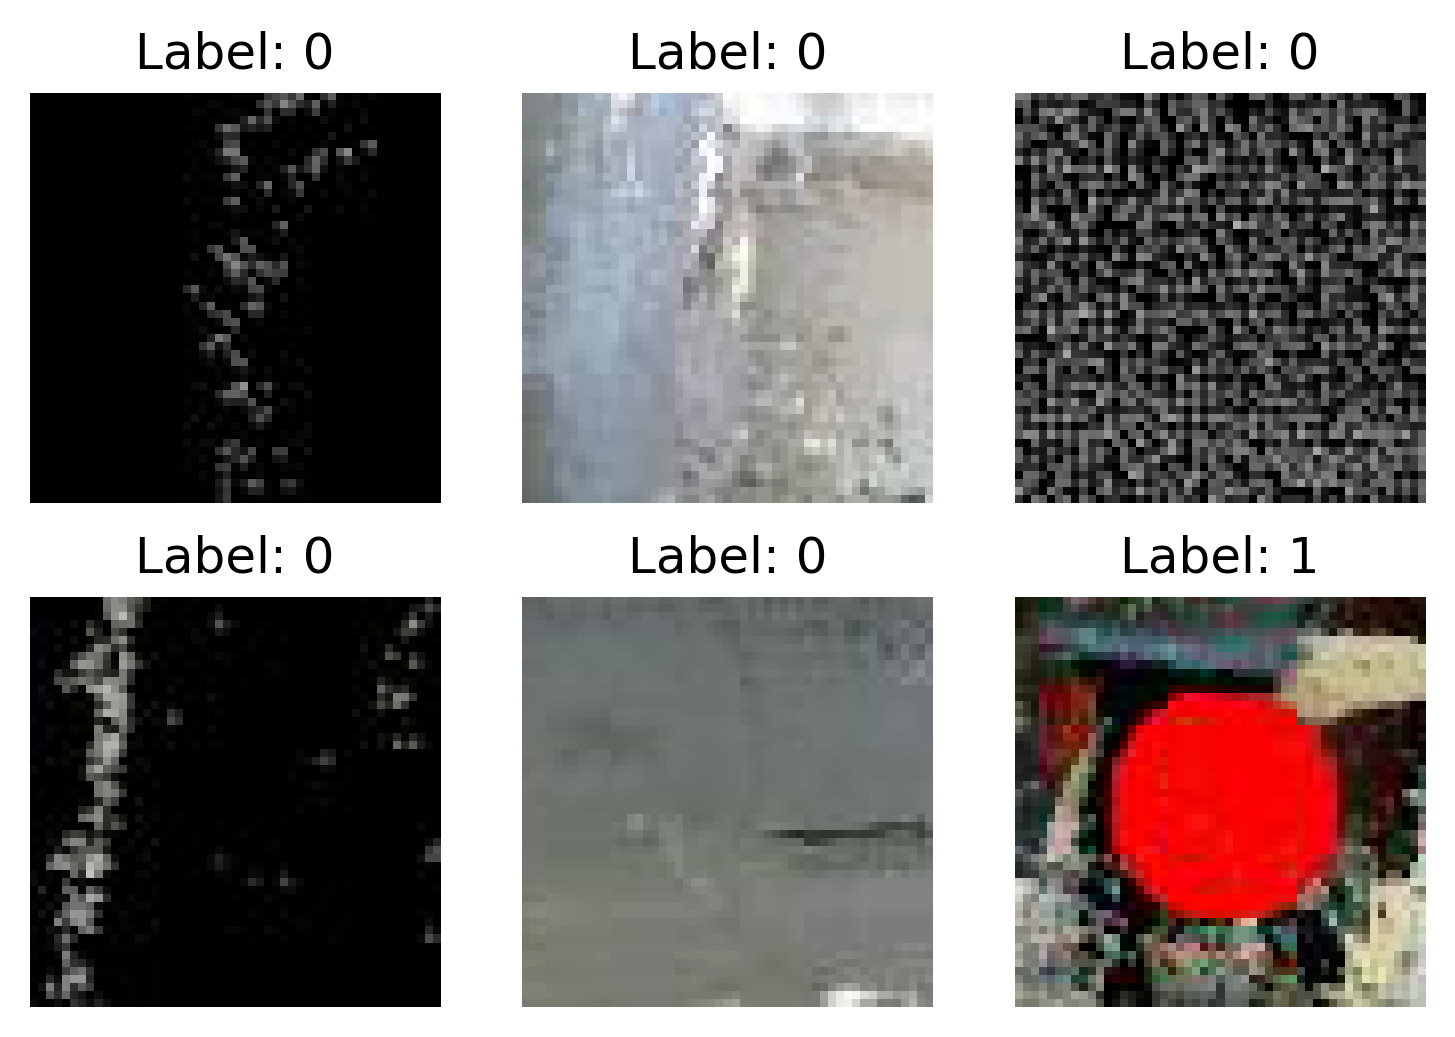

In [10]:
# get a batch size of data from data loader
images, labels = next(iter(train_loader))

# plot 6 examples in data loader
fig, axs = plt.subplots(2, 3, figsize=(6, 4), dpi = 300)

for i, ax in enumerate(axs.flat):
    # convert tensor to numpy
    img = images[i].numpy().transpose((1, 2, 0))
    
    # denormalise images
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # plot
    ax.imshow(img)
    ax.set_title(f'Label: {labels[i]}')
    ax.axis('off')

plt.show()

## Basic Solution : Train a DNN based binary classifier
Depending on your desired apporach, you may want to build a simple binary classification using the training patches you have been given. These can then be used to detect whether the image patch contains the target or not. Several backbone networks are talked about both in the lectures and labs. 

### Define the CNN Model

#### Create CNN Architecture

In [11]:
class SimpleCNN(nn.Module):
    """
    A simple convolutional neural network model for binary classification of images. 
    """
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # fully connected layers
        self.fc1 = nn.Linear(128 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)

        # dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # flatten image input
        x = x.view(-1, 128 * 6 * 6)

        # dropout layer
        x = self.dropout(x)

        # 1st fully connected layer with relu activation function
        x = F.relu(self.fc1(x))

        # dropout layer
        x = self.dropout(x)

        # 2nd fully connected layer with relu activation function
        x = F.relu(self.fc2(x))

        # dropout layer
        x = self.dropout(x)

        # 3rd fully connected layer with sigmoid activation function
        # Use sigmoid as this is binary classification
        x = torch.sigmoid(self.fc3(x))

        return x

#### Instantiate the model and send to GPU

In [12]:
model = SimpleCNN().to(device) # Move the model to GPU
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


#### Define the loss function and optimiser

In [13]:
criterion = nn.BCELoss() # The best one in this case
optimiser = optim.Adam(model.parameters(), lr=0.001) # General choice

#### Define the training function

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimiser, num_epochs=25, patience=1):
    best_model_wts = copy.deepcopy(model.state_dict()) # keep track of the model's best weights
    best_acc = 0.0
    epochs_no_improve = 0 # counter

    for epoch in range(num_epochs):
        model.train()  # set model to training mode
        
        running_loss = 0.0
        running_corrects = 0
        
        y_true_train = []
        y_pred_train = []
        
        # iterate over data.
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimiser.zero_grad()
            
            # forward
            outputs = model(inputs)
            preds = torch.round(outputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            
            # backward + optimise
            loss.backward()
            optimiser.step()
            
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.unsqueeze(1).data)
            
            y_true_train.extend(labels.tolist())
            y_pred_train.extend(preds.flatten().tolist())

        # calculation of various indicators
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        epoch_precision = precision_score(y_true_train, y_pred_train)
        epoch_recall = recall_score(y_true_train, y_pred_train)
        epoch_f1_score = f1_score(y_true_train, y_pred_train)
        
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}, F1-score: {epoch_f1_score:.4f}')
        
        # copy the model if it has better accuracy on the val-set
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        # if the model has not improved for 'patience' times, stop the loop early.
        if epochs_no_improve == patience:
            print('Early stopping initiated')
            break
        
        # validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        y_true_val = []
        y_pred_val = []

        # disable gradient calculation reduces memory usage and speeds up computations.
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # compute the model's predictions for the input data.
                outputs = model(inputs)
                preds = torch.round(outputs)
                loss = criterion(outputs, labels.unsqueeze(1).float())
                
                # aggregate the loss values over all validation samples.
                val_loss += loss.item() * inputs.size(0)
                # count how many predictions match the labels.
                val_corrects += torch.sum(preds == labels.unsqueeze(1).data)
                
                # extend the list of true labels with the labels
                y_true_val.extend(labels.tolist())
                # extend the list of predicted labels with the predictions
                y_pred_val.extend(preds.flatten().tolist())

            # calculation of various indicators
            val_loss = val_loss / len(val_loader.dataset)
            val_acc = val_corrects.double() / len(val_loader.dataset)
            
            val_precision = precision_score(y_true_val, y_pred_val)
            val_recall = recall_score(y_true_val, y_pred_val)
            val_f1_score = f1_score(y_true_val, y_pred_val)
            
            print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
            print(f'Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-score: {val_f1_score:.4f}')
            print()
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Train the Network

In [15]:
model = train_model(model, train_loader, val_loader, criterion, optimiser, num_epochs=25, patience=5)

Epoch 0/24
----------
Train Loss: 0.1733 Acc: 0.9445
Precision: 0.9905, Recall: 0.4815, F1-score: 0.6480
Validation Loss: 0.0120 Acc: 0.9977
Precision: 1.0000, Recall: 0.9783, F1-score: 0.9890

Epoch 1/24
----------
Train Loss: 0.0000 Acc: 1.0000
Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Validation Loss: 0.0215 Acc: 0.9862
Precision: 1.0000, Recall: 0.8696, F1-score: 0.9302

Epoch 2/24
----------
Train Loss: 0.0000 Acc: 1.0000
Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Validation Loss: 0.0473 Acc: 0.9817
Precision: 1.0000, Recall: 0.8261, F1-score: 0.9048

Epoch 3/24
----------
Train Loss: 0.0000 Acc: 1.0000
Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Validation Loss: 0.0547 Acc: 0.9817
Precision: 1.0000, Recall: 0.8261, F1-score: 0.9048

Epoch 4/24
----------
Train Loss: 0.0003 Acc: 1.0000
Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Validation Loss: 0.0134 Acc: 0.9977
Precision: 1.0000, Recall: 0.9783, F1-score: 0.9890

Epoch 5/24
----------
Train Lo

#### Save the Model
Save the trained model for future use.

In [20]:
#torch.save(model.state_dict(), 'models/CNN.pth')

### Test the Model
Evaluate the model's performance on the test dataset.

In [18]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # set model to evaluation mode
    test_loss = 0.0
    test_corrects = 0
    
    y_true_test = []
    y_pred_test = []
    
    with torch.no_grad():
        # Iterate over batches of data in the test loader
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            preds = torch.round(outputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            
            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.unsqueeze(1).data)
            
            y_true_test.extend(labels.tolist())
            y_pred_test.extend(preds.flatten().tolist())

        # calculation of various indicators
        test_loss = test_loss / len(test_loader.dataset)
        test_acc = test_corrects.double() / len(test_loader.dataset)
        
        test_precision = precision_score(y_true_test, y_pred_test)
        test_recall = recall_score(y_true_test, y_pred_test)
        test_f1_score = f1_score(y_true_test, y_pred_test)
        
        print('Test Results:')
        print('-' * 10)
        print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
        print(f'Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1_score:.4f}')

In [19]:
# criterion for evaluation /
criterion_eval = nn.BCELoss()

# evaluate the model on test set
start_time = time.time()
evaluate_model(model, test_loader, criterion_eval)
elapsed_time = time.time() - start_time
print(f'Elapsed Time: {elapsed_time:.4f} seconds') 

Test Results:
----------
Test Loss: 0.0211 Acc: 0.9817
Precision: 1.0000, Recall: 0.8261, F1-score: 0.9048
Elapsed Time: 0.0692 seconds


In [16]:
def visualise_predictions(model, test_loader, num_images=6):
    model.eval()  # Set model to evaluation mode
    images_handeled = 0 # Image counter
    plt.figure(figsize=(15, 20), dpi = 300) 

    with torch.no_grad(): # Ensure that all computations do not have gradients recorded by PyTorch to save memory and speed up computation. 
        for i, (inputs, labels) in enumerate(test_loader): # Get imgs and labels then move to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs) # Predict
            preds = torch.round(outputs) # Round the results to get the prediction value
            
            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 5, images_handeled)
                ax.axis('off')
                ax.set_title(f'True: {labels[j].item()} - Pred: {preds[j].item()}') # Showing real and predicted labels 
                input_img = inputs.cpu().data[j] # move the image tensor to cpu
                input_img = input_img.numpy().transpose((1, 2, 0)) # recover channels
                # denormalisation
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                input_img = std * input_img + mean
                input_img = np.clip(input_img, 0, 1) # Crops image data to between 0 and 1 
                plt.imshow(input_img)
                
                if images_handeled == num_images:
                    return
    plt.show()

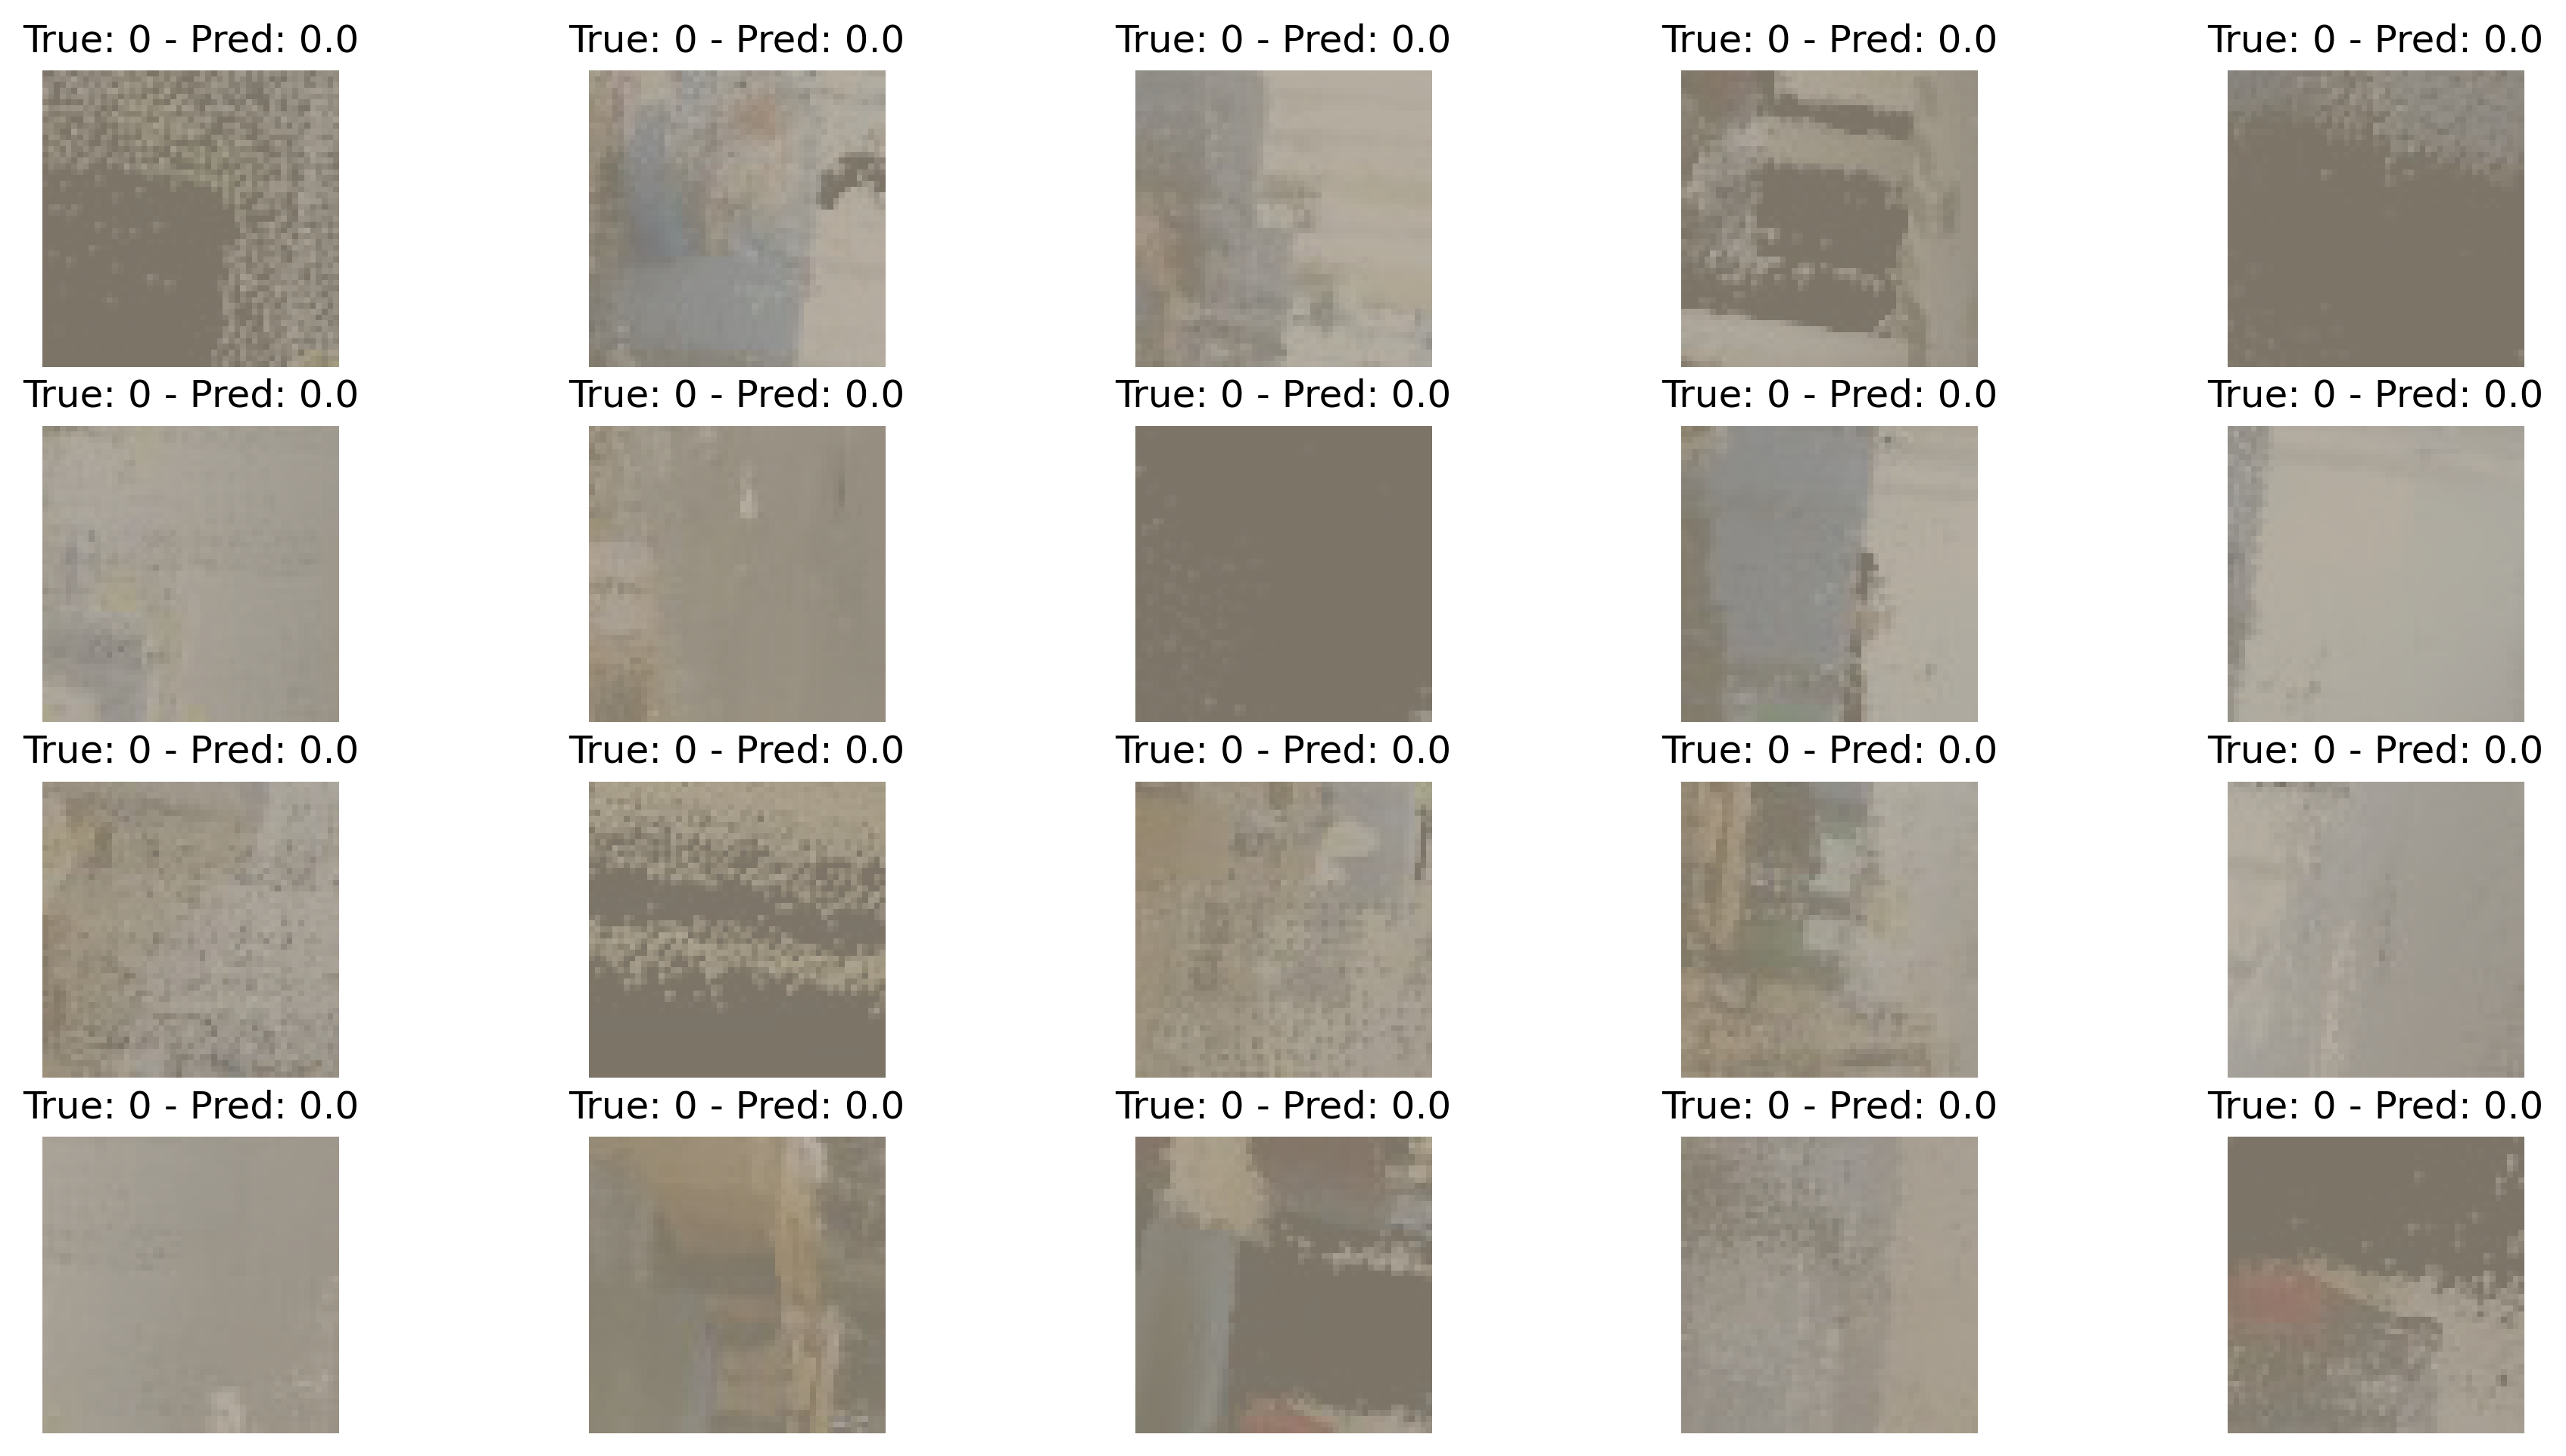

In [17]:
visualise_predictions(model, test_loader, num_images=20)

### Generate Training Data for Object DNN

In [10]:
model.load_state_dict(torch.load('models/CNN.pth'))
model.eval()  # Set the model to evaluation mode

# Create a dummy input that matches the input shape expected by the model
# For example, if your model takes a single image with 3 color channels and 224x224 resolution:
dummy_input = torch.randn(1, 3, 51, 51)  # Batch size is 1

# Specify the path to save the ONNX model
output_path = 'models/CNN.onnx'

# Export the model
torch.onnx.export(model,               # model being run
                  dummy_input,         # model input (or a tuple for multiple inputs)
                  output_path,         # where to save the model (can be a file or file-like object)
                  export_params=True,  # store the trained parameter weights inside the model file
                  opset_version=11,    # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names=['input'],   # the model's input names
                  output_names=['output'],  # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [7]:
model.load_state_dict(torch.load('models/CNN.pth')) # Load the trained model
model.eval() # Set evaluation mode
model.to(device) # Move the model to GPU

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [8]:
# Slide on a given image and extract the image block 
def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[0], step_size): # Vertical direction
        for x in range(0, image.shape[1] - window_size[1], step_size): # Horizontal direction
            yield x, y, image[y:y+window_size[0], x:x+window_size[1]] # Get the image block

In [9]:
# Detection on the input image by means of a sliding window 
def detect_targets(image, model, window_size, step_size, threshold=0.5):
    target_mask = np.zeros_like(image[:, :, 0])  # Create a mask for targets
    transform = transforms.Compose([
        transforms.Resize((51, 51)),  # Resize the input window to 51x51 (just in case)
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for x, y, window in sliding_window(image, step_size, window_size):
        window_uint8 = (window * 255).astype(np.uint8)  # Convert window to uint8
        window_image = Image.fromarray(window_uint8) # Convert uint8 format windows to PIL image objects 
        input_tensor = transform(window_image).unsqueeze(0).to(device) # Convert to tensor and move to GPU
        output = model(input_tensor) # Extracting scores from model outputs 
        score = output.item()

        if score >= threshold: # Check if the score is greater than or equal to the preset thresholds 
            target_mask[y:y+window_size[0], x:x+window_size[1]] = 1 # Marked as target present 

    return target_mask

In [20]:
# Get the map size
x_range, y_range, z_range = PacMan.calculate_pointcloud_bounds()
print("X Range:", x_range)
print("Y Range:", y_range)
print("Z Range:", z_range)

X Range: 17.798382
Y Range: 7.6320677
Z Range: 24.92617


In [21]:
# Define the range of positions and angles to traverse
map_size_x = int(x_range)
map_size_y = int(y_range)
map_size_z = int(z_range)

# Define the range of angles to traverse (reduced number of angles and larger step size)
angle_step = np.radians(90)  # 90 degrees step size
angles = np.arange(0, 2 * np.pi, angle_step)  # Angles from 0 to 360 degrees with 90 degrees step

In [24]:
# Save path
output_dir_positives = 'training_data/img/object_DNN/positives/'
output_dir_negatives = 'training_data/img/object_DNN/negatives/'

In [25]:
# Initialise Scene
global_cloud, spheres_collected = PacMan.startup_scene()

In [26]:
# x, y, z iterate over all possible positions in 3D space 
for x in range(map_size_x):
    for y in range(map_size_y):
        for z in range(map_size_z):
            position = np.array([x, y, z])
            for angle in angles:
                # Create rotation matrix from angle
                angle_rad = np.array([0, angle, 0]) # Rotate around the coordinate axis 
                image, _, _, _, _ = PacMan.project_pointcloud_image(global_cloud, angle_rad, position)
                
                # Detect targets in the image
                window_size = (51, 51) # Model's input size
                step_size = 5 # Adjust step size as needed
                target_mask = detect_targets(image, model, window_size, step_size) # Call the function
                
                # Save the png format image based on the presence of targets
                image_uint8 = (image * 255).astype(np.uint8)
                image_pil = Image.fromarray(image_uint8)
                
                if np.any(target_mask):
                    # Save the image in the positives directory if a target is detected
                    image_pil.save(os.path.join(output_dir_positives, f'image_pos_{position}_angle_{angle}.png'))
                else:
                    # Save the image in the negatives directory if no target is detected
                    image_pil.save(os.path.join(output_dir_negatives, f'image_pos_{position}_angle_{angle}.png'))

## Advance Solution : Train a DNN based object detector
Depending on your desired apporach, you may want to create a suitable dataset using both the training patches you have been given and the 3D point cloud dataset. These can then be used to train our desired object detector to detect the target in the image. Several object detection frameworks are talked about both in the lectures and labs. 

In [2]:
# Load a model
model = YOLO('models/yolov8m.pt')

### Train the Model

> The detailed model training parameters are in the file `training_data/YOLO/PacMan.yaml`. And I will explain it in the report as well. 

In [3]:
# Train the model
results = model.train(data='training_data/YOLO/PacMan.yaml')

Ultralytics YOLOv8.2.2 🚀 Python-3.11.7 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3070, 7971MiB)
engine/trainer: task=detect, mode=train, model=models/yolov8m.pt, data=training_data/YOLO/PacMan.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tr

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 755k/755k [00:00<00:00, 8.61MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

Model summary: 295 layers, 25856899 parameters, 25856883 gradients, 79.1 GFLOPs

Transferred 469/475 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6.23M/6.23M [00:00<00:00, 18.0MB/s]


AMP: checks passed ✅


train: Scanning /home/adrian/OneDrive/Documents/Master of Computer Science/Deep Learning for CV and Robotics/Summative/dl-cv-robotics/training_data/YOLO/train... 721 images, 545 backgrounds, 0 corrupt: 100%|██████████| 721/721 [00:00<00:00, 9692.20it/s]

train: New cache created: /home/adrian/OneDrive/Documents/Master of Computer Science/Deep Learning for CV and Robotics/Summative/dl-cv-robotics/training_data/YOLO/train.cache



val: Scanning /home/adrian/OneDrive/Documents/Master of Computer Science/Deep Learning for CV and Robotics/Summative/dl-cv-robotics/training_data/YOLO/val... 206 images, 150 backgrounds, 0 corrupt: 100%|██████████| 206/206 [00:00<00:00, 8487.24it/s]


val: New cache created: /home/adrian/OneDrive/Documents/Master of Computer Science/Deep Learning for CV and Robotics/Summative/dl-cv-robotics/training_data/YOLO/val.cache
Plotting labels to runs/detect/train7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train7
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.59G      1.058      4.431     0.9809          3        640: 100%|██████████| 46/46 [00:14<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.89it/s]

                   all        206        134     0.0125      0.888     0.0123    0.00785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.79G      1.175     0.9849      1.032          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.05it/s]

                   all        206        134      0.676      0.373      0.355      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.84G      1.223      1.139      1.057          1        640: 100%|██████████| 46/46 [00:12<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.31it/s]

                   all        206        134      0.214      0.112     0.0462     0.0196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.79G      1.208      0.922      1.075          1        640: 100%|██████████| 46/46 [00:12<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]

                   all        206        134   4.87e-05     0.0224   3.18e-05    1.3e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.82G      1.121     0.8748      1.057          2        640: 100%|██████████| 46/46 [00:12<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.09it/s]

                   all        206        134      0.887      0.878      0.923      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.79G      1.121     0.7858      1.021          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.07it/s]

                   all        206        134      0.824       0.91      0.937      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.83G      1.138     0.7846      1.061          1        640: 100%|██████████| 46/46 [00:12<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.26it/s]

                   all        206        134      0.877      0.828      0.933      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       6.8G      1.041     0.6886      1.002          2        640: 100%|██████████| 46/46 [00:12<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.23it/s]

                   all        206        134      0.854      0.828      0.928      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.83G      1.087     0.7537      1.046          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.98it/s]

                   all        206        134      0.888      0.903       0.96      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       6.8G      1.016     0.6734     0.9976          1        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.32it/s]

                   all        206        134       0.92      0.858       0.96      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.82G     0.9938     0.6428     0.9608          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.16it/s]

                   all        206        134      0.875      0.873      0.938      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.81G     0.9891     0.6669     0.9675          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.45it/s]

                   all        206        134      0.872      0.851      0.937      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.84G     0.9738     0.6479     0.9975          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.46it/s]

                   all        206        134      0.906      0.873      0.953      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.79G     0.9598     0.6319     0.9551          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.19it/s]

                   all        206        134      0.898      0.896      0.963      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.81G      1.012     0.6989     0.9718          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.07it/s]

                   all        206        134      0.889      0.903      0.962      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.81G     0.9427     0.6123     0.9377          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.43it/s]

                   all        206        134      0.872       0.91      0.954      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.84G     0.9368     0.6112     0.9483          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.46it/s]

                   all        206        134      0.856      0.935      0.962      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.79G     0.8597     0.5466     0.9169          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.17it/s]

                   all        206        134      0.863      0.943      0.966      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.81G      0.902     0.5235     0.9527          2        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.44it/s]

                   all        206        134      0.893      0.925      0.962      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       6.8G     0.8973     0.5748     0.9511          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.44it/s]

                   all        206        134      0.925      0.858      0.963      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.84G     0.8923     0.5551     0.9398          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.24it/s]

                   all        206        134      0.898      0.917       0.97      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       6.8G     0.8692     0.5834     0.9371          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.42it/s]

                   all        206        134      0.896      0.948      0.965      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.82G     0.8941     0.8108      0.899          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.44it/s]

                   all        206        134       0.85      0.963      0.959      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.79G     0.9293     0.5841      0.965          1        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.25it/s]

                   all        206        134      0.884      0.906      0.968      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.82G     0.8527     0.5275      0.913          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.45it/s]

                   all        206        134      0.872      0.969      0.968       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.81G     0.8599     0.5499     0.9129          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.45it/s]

                   all        206        134      0.893      0.888      0.966      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.83G     0.8837     0.5507      0.917          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.44it/s]

                   all        206        134      0.933      0.933      0.975      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       6.8G      0.904     0.5604     0.9614          2        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.46it/s]

                   all        206        134      0.875      0.933       0.96       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.83G     0.8431     0.5115     0.9195          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.43it/s]

                   all        206        134      0.944      0.885      0.975      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.79G     0.8351     0.5139     0.9252          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.45it/s]

                   all        206        134      0.888      0.955      0.969      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.83G     0.8532     0.5273     0.9262          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.18it/s]

                   all        206        134      0.891      0.913      0.967      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.79G     0.8777     0.4914      0.901          2        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.43it/s]

                   all        206        134      0.901       0.97      0.977      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.84G     0.8533     0.5195     0.9296          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.45it/s]

                   all        206        134      0.899       0.94      0.973      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.79G     0.8747     0.5197     0.9422          1        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.46it/s]

                   all        206        134      0.888      0.918      0.971      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.83G     0.8244     0.4991     0.8879          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.42it/s]

                   all        206        134      0.899      0.896      0.965      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       6.8G     0.8251      0.524     0.8998          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.46it/s]

                   all        206        134      0.856       0.91      0.959      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.82G     0.8172     0.5015     0.9355          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.41it/s]

                   all        206        134       0.87      0.918      0.962      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       6.8G     0.8232     0.4966     0.9403          2        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.19it/s]

                   all        206        134      0.897      0.912      0.971      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.83G     0.7773     0.4757     0.8943          1        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.45it/s]

                   all        206        134      0.891      0.948      0.977      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.79G     0.8167     0.4881      0.898          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.46it/s]

                   all        206        134      0.921      0.874      0.968      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.84G     0.8079     0.4799     0.9192          2        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.41it/s]

                   all        206        134      0.861      0.925      0.962      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.79G     0.8526     0.5035      0.943          2        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.45it/s]

                   all        206        134      0.916      0.901      0.971      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.81G     0.7892     0.4991     0.8992          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.44it/s]

                   all        206        134      0.919      0.932      0.973      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       6.8G     0.8642     0.5462     0.9375          3        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.46it/s]

                   all        206        134      0.897      0.918      0.972       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.82G     0.8019      0.478     0.9025          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.16it/s]

                   all        206        134      0.904       0.94      0.977      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.79G     0.7989      0.475     0.9011          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.14it/s]

                   all        206        134      0.933      0.903      0.971      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.83G     0.8303     0.5019     0.9137          4        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.42it/s]

                   all        206        134      0.874      0.948      0.972      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.81G     0.8357     0.4868     0.9145          3        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.46it/s]

                   all        206        134      0.912      0.932      0.974      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.82G     0.8016     0.4753     0.9079          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.47it/s]

                   all        206        134      0.842      0.993      0.969      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.81G     0.8328     0.4828     0.9282          1        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.45it/s]

                   all        206        134      0.914      0.873      0.967      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.82G       0.78      0.468      0.886          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.17it/s]

                   all        206        134        0.9      0.918      0.972       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.79G     0.7665     0.4535     0.8829          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.40it/s]

                   all        206        134       0.86      0.959      0.973      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.82G     0.7791     0.4688     0.8983          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.47it/s]

                   all        206        134      0.935      0.896      0.974      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.79G      0.778     0.4558     0.8866          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.44it/s]

                   all        206        134      0.913      0.942      0.973      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.82G     0.7696     0.4645     0.8749          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.44it/s]

                   all        206        134      0.886      0.955      0.975      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       6.8G     0.7464      0.439     0.8959          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.46it/s]

                   all        206        134      0.861      0.968      0.971       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.83G     0.7655     0.4587     0.8996          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.41it/s]

                   all        206        134      0.865      0.955      0.961      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.79G     0.7863     0.4444     0.8867          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.46it/s]

                   all        206        134      0.886      0.933      0.965      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.82G     0.7461     0.4166     0.8695          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.47it/s]

                   all        206        134      0.934      0.943      0.976      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       6.8G     0.7339     0.4212     0.8758          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.46it/s]

                   all        206        134      0.888      0.948      0.975      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.82G     0.7418     0.4345     0.8905          6        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.45it/s]

                   all        206        134      0.921      0.956      0.979      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       6.8G     0.7691     0.4278     0.8751          1        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.47it/s]

                   all        206        134      0.931      0.933      0.975      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.83G     0.7303     0.5265     0.8748          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.42it/s]

                   all        206        134      0.912       0.94      0.973      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.79G     0.7253     0.4122     0.8448          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.45it/s]

                   all        206        134      0.894      0.963      0.973      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.83G      0.731     0.4483     0.8882          1        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.45it/s]

                   all        206        134      0.902      0.962      0.975      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       6.8G     0.7709     0.4738     0.8718          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.34it/s]

                   all        206        134      0.968      0.925      0.981      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.83G     0.7468     0.4305     0.8941          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.16it/s]

                   all        206        134       0.92      0.948      0.981      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       6.8G     0.7213     0.4166     0.8753          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.17it/s]

                   all        206        134       0.93      0.948       0.98      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.82G     0.7384     0.4242     0.8769          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.45it/s]

                   all        206        134      0.915      0.933      0.976      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.79G     0.6877     0.3945     0.8543          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.45it/s]

                   all        206        134      0.913       0.94      0.975      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.83G     0.7373     0.5892     0.8768          1        640: 100%|██████████| 46/46 [00:12<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.32it/s]

                   all        206        134      0.886      0.932      0.965       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.79G     0.7161     0.3904     0.8631          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.32it/s]

                   all        206        134      0.912      0.926      0.979      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.81G     0.7144      0.399     0.8765          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.26it/s]

                   all        206        134      0.908       0.94      0.975      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       6.8G     0.7105     0.4155     0.8676          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.02it/s]

                   all        206        134      0.937       0.91      0.975      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.83G     0.7423     0.4314     0.8813          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]

                   all        206        134      0.935      0.933      0.978      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.79G     0.7626       0.42     0.9578          1        640: 100%|██████████| 46/46 [00:12<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.11it/s]

                   all        206        134      0.906      0.931       0.97       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.82G     0.7154     0.4031     0.8772          2        640: 100%|██████████| 46/46 [00:12<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.07it/s]

                   all        206        134      0.934       0.94      0.977      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.78G     0.6846     0.3982     0.8846          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.43it/s]

                   all        206        134      0.905      0.948      0.977      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.82G     0.6825     0.4192     0.8605          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.27it/s]

                   all        206        134      0.946      0.916      0.975      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       6.8G      0.711     0.4033     0.8905          1        640: 100%|██████████| 46/46 [00:12<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.27it/s]

                   all        206        134      0.946      0.918      0.979      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.82G     0.6672     0.3922     0.8513          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.41it/s]

                   all        206        134      0.947      0.926      0.982      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       6.8G     0.7047     0.4018     0.9051          3        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.42it/s]

                   all        206        134      0.918      0.955      0.978       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.82G     0.7123     0.3927     0.8725          5        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.39it/s]

                   all        206        134      0.917       0.97      0.979      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.79G     0.6533     0.3752     0.8434          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.22it/s]

                   all        206        134      0.903       0.97       0.98      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.81G     0.6885     0.3608     0.8652          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.12it/s]

                   all        206        134       0.92      0.949      0.981      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       6.8G     0.6939     0.3695     0.8861          4        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.30it/s]

                   all        206        134      0.942       0.94      0.983      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.83G     0.6701     0.3531     0.8803          1        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.40it/s]

                   all        206        134      0.913       0.94      0.977      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.79G     0.6678     0.3576     0.8681          1        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.41it/s]

                   all        206        134      0.932      0.921      0.978       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.82G     0.6901     0.3655     0.8696          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.43it/s]

                   all        206        134      0.913      0.944      0.977      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       6.8G     0.6765     0.3546     0.8592          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.41it/s]

                   all        206        134      0.927      0.963      0.982      0.777


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.83G     0.6992     0.3791     0.8825          2        640: 100%|██████████| 46/46 [00:12<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.41it/s]

                   all        206        134      0.944       0.94      0.982      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.81G     0.6742     0.3571      0.871          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.42it/s]

                   all        206        134      0.925      0.963      0.983      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.81G     0.7136     0.4053     0.8988          1        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.41it/s]

                   all        206        134      0.917      0.978      0.981      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       6.8G     0.6794     0.3576     0.8812          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.41it/s]

                   all        206        134      0.937      0.955      0.981      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.83G     0.6886     0.3452     0.8664          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.40it/s]

                   all        206        134      0.914      0.949       0.98      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       6.8G     0.6725     0.3364     0.8773          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.42it/s]

                   all        206        134      0.948       0.94      0.981      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.82G     0.6282     0.3489     0.8473          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.41it/s]

                   all        206        134      0.939       0.94      0.977      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.81G      0.648     0.3273     0.8572          4        640: 100%|██████████| 46/46 [00:12<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.42it/s]

                   all        206        134      0.943       0.94      0.976      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.83G     0.6088     0.3103      0.809          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.41it/s]

                   all        206        134      0.938      0.933      0.973      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.78G     0.6539     0.3303     0.8418          0        640: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.41it/s]

                   all        206        134      0.914      0.955      0.976      0.778



100 epochs completed in 0.382 hours.
Optimizer stripped from runs/detect/train7/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 52.0MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics YOLOv8.2.2 🚀 Python-3.11.7 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3070, 7971MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


                   all        206        134      0.948       0.94      0.981      0.783
Speed: 0.1ms preprocess, 3.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/train7


In [ ]:
# Uncomment it if you want to train it again. 
#model.save('models/YOLO.pt')

### Evaluate the Model

In [16]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # set model to evaluation mode
    test_loss = 0.0
    test_corrects = 0
    
    y_true_test = []
    y_pred_test = []
    
    with torch.no_grad():
        # Iterate over batches of data in the test loader
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            preds = torch.round(outputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            
            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.unsqueeze(1).data)
            
            y_true_test.extend(labels.tolist())
            y_pred_test.extend(preds.flatten().tolist())

        # calculation of various indicators
        test_loss = test_loss / len(test_loader.dataset)
        test_acc = test_corrects.double() / len(test_loader.dataset)
        
        test_precision = precision_score(y_true_test, y_pred_test)
        test_recall = recall_score(y_true_test, y_pred_test)
        test_f1_score = f1_score(y_true_test, y_pred_test)
        
        print('Test Results:')
        print('-' * 10)
        print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
        print(f'Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1_score:.4f}')

In [17]:
# criterion for evaluation /
criterion_eval = nn.BCELoss()

# evaluate the model on test set
start_time = time.time()
evaluate_model(model, test_loader, criterion_eval)
elapsed_time = time.time() - start_time
print(f'Elapsed Time: {elapsed_time:.4f} seconds') 

Test Results:
----------
Test Loss: 0.0173 Acc: 0.9931
Precision: 1.0000, Recall: 0.9348, F1-score: 0.9663


In [ ]:
benchmark(model='models/YOLO.pt', data='training_data/YOLO/PacMan.yaml', imgsz=640, half=False, device=0)


image 1/1 /home/adrian/anaconda3/lib/python3.11/site-packages/ultralytics/assets/bus.jpg: 640x480 (no detections), 54.7ms
Speed: 0.9ms preprocess, 54.7ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 480)


val: Scanning /home/adrian/OneDrive/Documents/Master of Computer Science/Deep Learning for CV and Robotics/Summative/dl-cv-robotics/training_data/YOLO/val.cache... 206 images, 150 backgrounds, 0 corrupt: 100%|██████████| 206/206 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 206/206 [00:02<00:00, 89.99it/s] 

                   all        206        134      0.948       0.94      0.981      0.785
Speed: 0.1ms preprocess, 7.8ms inference, 0.0ms loss, 0.9ms postprocess per image

PyTorch: starting from 'models/YOLO.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (49.6 MB)

TorchScript: starting export with torch 2.2.2+cu121...


TorchScript: export success ✅ 0.7s, saved as 'models/YOLO.torchscript' (99.1 MB)

Export complete (0.7s)
Results saved to /home/adrian/OneDrive/Documents/Master of Computer Science/Deep Learning for CV and Robotics/Summative/dl-cv-robotics/models
Predict:         yolo predict task=detect model=models/YOLO.torchscript imgsz=640  
Validate:        yolo val task=detect model=models/YOLO.torchscript imgsz=640 data=training_data/YOLO/PacMan.yaml  
Visualize:       https://netron.app
Loading models/YOLO.torchscript for TorchScript inference...

image 1/1 /home/adrian/anaconda3/lib/python3.11/site-packages/ultralytics/assets/bus.jpg: 640x640 (no detections), 8.9ms
Speed: 1.0ms preprocess, 8.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Loading models/YOLO.torchscript for TorchScript inference...


val: Scanning /home/adrian/OneDrive/Documents/Master of Computer Science/Deep Learning for CV and Robotics/Summative/dl-cv-robotics/training_data/YOLO/val.cache... 206 images, 150 backgrounds, 0 corrupt: 100%|██████████| 206/206 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 206/206 [00:02<00:00, 102.17it/s]

                   all        206        134      0.941       0.94      0.981      0.788
Speed: 0.1ms preprocess, 9.1ms inference, 0.0ms loss, 0.2ms postprocess per image

PyTorch: starting from 'models/YOLO.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (49.6 MB)

ONNX: starting export with onnx 1.16.0 opset 17...


ONNX: export success ✅ 0.7s, saved as 'models/YOLO.onnx' (98.8 MB)

Export complete (0.8s)
Results saved to /home/adrian/OneDrive/Documents/Master of Computer Science/Deep Learning for CV and Robotics/Summative/dl-cv-robotics/models
Predict:         yolo predict task=detect model=models/YOLO.onnx imgsz=640  
Validate:        yolo val task=detect model=models/YOLO.onnx imgsz=640 data=training_data/YOLO/PacMan.yaml  
Visualize:       https://netron.app
Loading models/YOLO.onnx for ONNX Runtime inference...
requirements: Ultralytics requirement ['onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.1/192.1 MB 6.9 MB/s eta 0:00:00m eta 0:00:010:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 32.4 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 25.0s, installed 1 package: ['onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for

val: Scanning /home/adrian/OneDrive/Documents/Master of Computer Science/Deep Learning for CV and Robotics/Summative/dl-cv-robotics/training_data/YOLO/val.cache... 206 images, 150 backgrounds, 0 corrupt: 100%|██████████| 206/206 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 206/206 [00:01<00:00, 124.51it/s]

                   all        206        134      0.941       0.94      0.981      0.788
Speed: 0.1ms preprocess, 7.3ms inference, 0.0ms loss, 0.2ms postprocess per image
ERROR ❌️ Benchmark failure for CoreML: inference not supported on GPU

PyTorch: starting from 'models/YOLO.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (49.6 MB)
requirements: Ultralytics requirement ['tensorflow<=2.13.1'] not found, attempting AutoUpdate...



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.2.2 requires typing-extensions>=4.8.0, but you have typing-extensions 4.5.0 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.6/479.6 MB 21.1 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 21.1 MB/s eta 0:00:0031m21.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 21.1 MB/s eta 0:00:0031m21.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.0 MB/s eta 0:00:0031m21.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 21.1 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 21.1 MB/s eta 0:00:0031m21.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 21.7 MB/s eta 0:0

ERROR: Operation cancelled by user


Retry 1/2 failed: 
requirements: AutoUpdate success ✅ 5.0s, installed 2 packages: ['paddlepaddle', 'x2paddle']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

PaddlePaddle: export failure ❌ 5.0s: No module named 'x2paddle'
ERROR ❌️ Benchmark failure for PaddlePaddle: No module named 'x2paddle'

PyTorch: starting from 'models/YOLO.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (49.6 MB)

TorchScript: starting export with torch 2.2.2+cu121...
TorchScript: export success ✅ 0.7s, saved as 'models/YOLO.torchscript' (99.1 MB)
requirements: Ultralytics requirement ['ncnn'] not found, attempting AutoUpdate...


## Perform a detection-navigation loop to collect all objects.
This will be the main bulk of your implementation, utilising the trained models from the above cells. In each loop of the program we will want to:
-  Get current view into the scene, and use the trained model to detect the sphere
-  Collect the sphere by moving towards it. If you land close enough to the object it will be automatically captured and removed from the scene. 


In [5]:
def predict_target_position(model, image, mapx, mapy, mapz, depth):
    # Run inference on the image using your YOLO model
    results = model(image)

    # Process the results
    for result in results:
        boxes = result.boxes

        # Check if any target spheres are detected
        if len(boxes) > 0:
            # Get the bounding box coordinates of the first detected sphere
            target_bbox = boxes[0].xyxy.cpu().numpy().squeeze()

            # Get the center coordinates of the target bounding box
            center_x = (target_bbox[0] + target_bbox[2]) // 2
            center_y = (target_bbox[1] + target_bbox[3]) // 2

            # Get the corresponding 3d coordinates and depth value
            target_x = mapx[int(center_y), int(center_x)]
            target_y = mapy[int(center_y), int(center_x)]
            target_z = mapz[int(center_y), int(center_x)]
            target_depth = depth[int(center_y), int(center_x)]

            # Create the target position array
            target_position = np.array([target_x, target_y, target_z])

            return target_position

    # Return None if no target spheres are detected
    return None

In [6]:
def capture_spheres(global_cloud, spheres_collected):

    # Conifigurations
    # Load the pre-trained YOLO model
    model = YOLO('models/YOLO.pt')

    # Initialise position and angle variables
    position = np.zeros(3)
    angle = np.zeros(3)

    # Maximum number of iterations
    max_iterations = 100

    # Angle step size for steering
    angle_step = np.pi / 2  # 90 degrees

    # Position step size for movement
    position_step = 1

    # maximum number of consecutive no detections before moving
    max_no_detections = 4

    # Initialise the consecutive no detections counter
    consecutive_no_detections = 0

    # Get point cloud bounds
    x_range, y_range, z_range = PacMan.calculate_pointcloud_bounds()


    # Catching targets
    # Iterate until all spheres are collected or the maximum number of iterations is reached
    for i in range(max_iterations):
        # Capture an image and its corresponding maps
        image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, angle, position)

        # Convert the image to PIL Image format
        pil_image = Image.fromarray(np.uint8(image * 255))

        # Predict the target position
        predicted_position = predict_target_position(model, pil_image, mapx, mapy, mapz, depth)

        # Print the current position and angle
        print(f"Current Position: {position}")
        print(f"Current Angle: {angle}")

        if predicted_position is not None:
            # Reset the consecutive no detections counter
            consecutive_no_detections = 0

            # Update the current position to the predicted target position
            position = predicted_position

            # Update the scene and check if the sphere is captured
            prev_collected_count = sum(spheres_collected)
            global_cloud, spheres_collected = PacMan.update_scene(position, spheres_collected)

            # Check if a new sphere is captured
            if sum(spheres_collected) > prev_collected_count:
                # Print the number of spheres collected
                print(f"Spheres Collected: {sum(spheres_collected)}")
                print("---")

            # Check if all spheres are collected
            if all(spheres_collected):
                print("One shot clear!")
                break
        else:
            # Increment the consecutive no detections counter
            consecutive_no_detections += 1

            # If the consecutive no detections exceed the maximum limit
            if consecutive_no_detections >= max_no_detections:
                # Reset the consecutive no detections counter
                consecutive_no_detections = 0

                # Move the camera position based on the current angle
                position[0] += position_step * np.cos(angle[1])  # Move in the x-direction
                position[2] += position_step * np.sin(angle[1])  # Move in the z-direction

                # Check if new position is within boundaries, otherwise reverse angle
                if not (0 <= position[0] <= x_range and 0 <= position[2] <= z_range):
                    angle[1] += np.pi / 2  # Reverse direction

            # Normalize the angle to keep it within the range [-pi, pi]
            angle[1] = np.arctan2(np.sin(angle[1]), np.cos(angle[1]))

    print("Capturing spheres completed.")
    
    # Visualise the final 3D world using Open3D
    return global_cloud

In [7]:
start_time = time.time()
final_world = capture_spheres(global_cloud, spheres_collected)
elapsed_time = time.time() - start_time
print(f'Elapsed Time: {elapsed_time:.4f} seconds') 


0: 448x640 3 targets, 55.6ms
Speed: 2.1ms preprocess, 55.6ms inference, 187.2ms postprocess per image at shape (1, 3, 448, 640)
Current Position: [          0           0           0]
Current Angle: [          0           0           0]
Spheres Collected: 1
---

0: 448x640 3 targets, 8.3ms
Speed: 0.7ms preprocess, 8.3ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)
Current Position: [   -0.18764    0.057548      2.3094]
Current Angle: [          0           0           0]
Spheres Collected: 2
---

0: 448x640 2 targets, 8.3ms
Speed: 0.7ms preprocess, 8.3ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)
Current Position: [   -0.31516   -0.034299      4.6735]
Current Angle: [          0           0           0]
Spheres Collected: 3
---

0: 448x640 2 targets, 7.8ms
Speed: 0.7ms preprocess, 7.8ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)
Current Position: [   -0.92114     0.19851      7.0118]
Current Angle: [          0           

## Display the Result


In [12]:
np.save('training_data/npy/final_world_positions.npy', final_world['Positions'])
np.save('training_data/npy/final_world_colors.npy', final_world['Colors'])

In [13]:
pcd = open3d.geometry.PointCloud(open3d.utility.Vector3dVector(final_world['Positions']))
pcd.colors = open3d.utility.Vector3dVector(final_world['Colors']/255)

open3d.visualization.draw_geometries([pcd])